In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("monthly-milk-production-pounds.csv",parse_dates=True)
df

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0
...,...,...
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [3]:
df.columns

Index(['Month', 'Monthly milk production: pounds per cow. Jan 62 ? Dec 75'], dtype='object')

In [4]:
df['Production']=df['Monthly milk production: pounds per cow. Jan 62 ? Dec 75']

In [5]:
df=df.drop('Monthly milk production: pounds per cow. Jan 62 ? Dec 75',axis=1)

In [6]:
df.isnull().sum()

Month         0
Production    1
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df

,Month,Production
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0
...,...,...
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0


<Axes: >

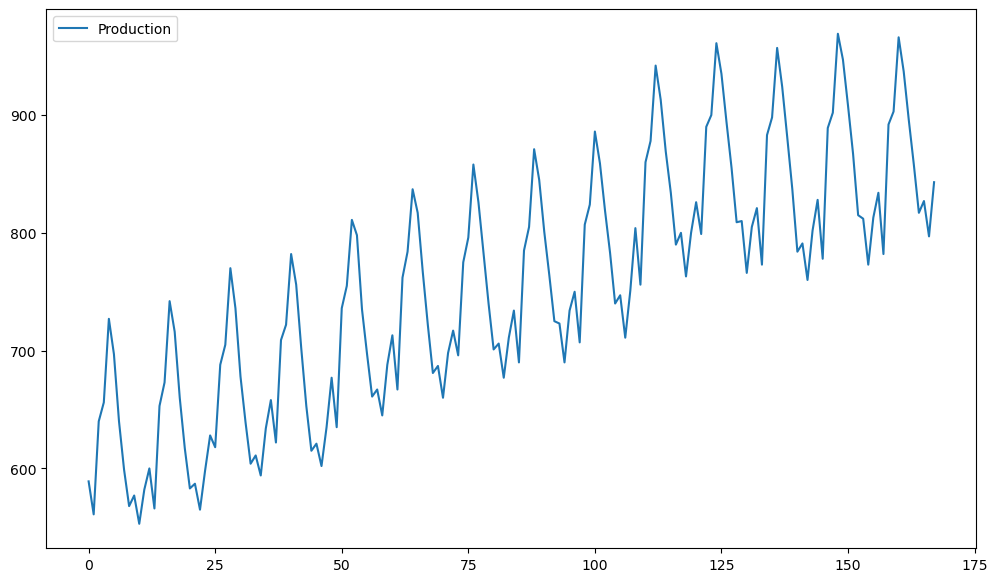

In [9]:
df.plot(figsize=(12,7))

In [10]:
df.dtypes

Month          object
Production    float64
dtype: object

In [11]:
df['Month']=df['Month'].astype('datetime64[ns]')

In [12]:
df.dtypes

Month         datetime64[ns]
Production           float64
dtype: object

In [13]:
df.set_index('Month',inplace=True)

In [14]:
df

,Production
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0
...,...
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

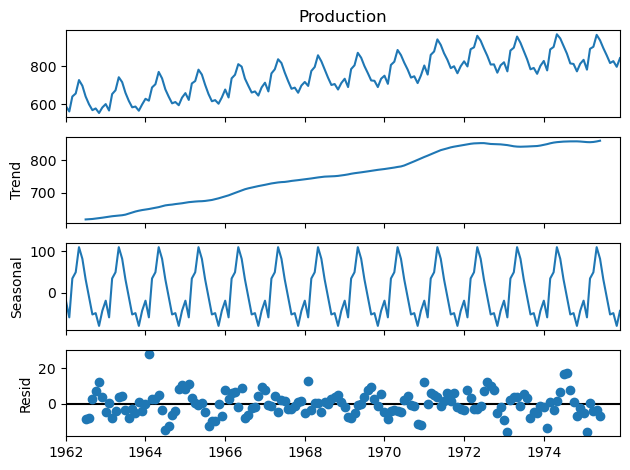

In [16]:
result=seasonal_decompose(df['Production'])
result.plot();

In [17]:
len(df)

168

In [18]:
train=df.iloc[:156]
test=df.iloc[156:]

In [19]:
test

,Production
Month,
1975-01-01,834.0
1975-02-01,782.0
1975-03-01,892.0
1975-04-01,903.0
1975-05-01,966.0
1975-06-01,937.0
1975-07-01,896.0
1975-08-01,858.0
1975-09-01,817.0


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [21]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
n_input=3
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [24]:
print(len(scaled_train),len(generator))

156 153


In [25]:
X,y=generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
[[0.24759615]]


In [26]:
X.shape

(1, 3, 1)

In [27]:
# We do the same thing, but now instead for 12 months
n_input=12
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [29]:
model=Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

C:\Users\yasha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.fit(generator,epochs=50)

Epoch 1/50
  8/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3045 

C:\Users\yasha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0876
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0229
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0135
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0105
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0062
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0028
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039


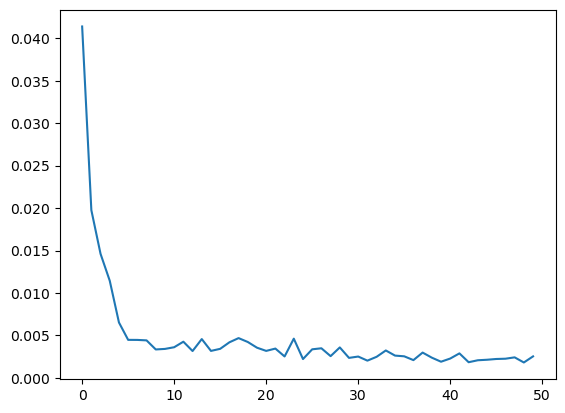

In [50]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [51]:
last_train_batch=scaled_train[-12:]

In [52]:
last_train_batch=last_train_batch.reshape((1,n_input,n_features))

In [53]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


array([[0.63739294]], dtype=float32)

In [54]:
scaled_test[0]

array([0.67548077])

In [57]:
test_predictions=[]

first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
    
    current_pred=model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [58]:
test_predictions

[array([0.63739294], dtype=float32),
 array([0.59135467], dtype=float32),
 array([0.7889387], dtype=float32),
 array([0.8557869], dtype=float32),
 array([0.96585554], dtype=float32),
 array([0.9390808], dtype=float32),
 array([0.8587965], dtype=float32),
 array([0.7555743], dtype=float32),
 array([0.6537166], dtype=float32),
 array([0.62397015], dtype=float32),
 array([0.5693737], dtype=float32),
 array([0.60116893], dtype=float32)]

In [59]:
test.head()

,Production
Month,
1975-01-01,834.0
1975-02-01,782.0
1975-03-01,892.0
1975-04-01,903.0
1975-05-01,966.0


In [60]:
true_predictions=scaler.inverse_transform(test_predictions)

In [61]:
test['Predictions']=true_predictions

C:\Users\yasha\AppData\Local\Temp\ipykernel_29092\2664784394.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions']=true_predictions


<Axes: xlabel='Month'>

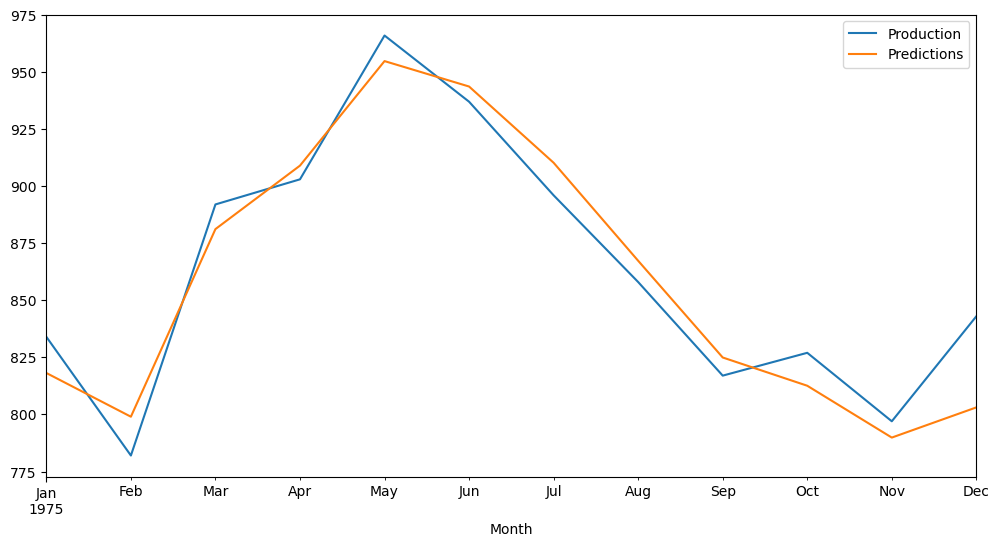

In [62]:
test.plot(figsize=(12,6))

In [63]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

15.990541894236388
